# Assignment 3: Recurrent Neural Network (RNN)

In this assignment, we will build different Recurrent Neural Networks (i.e. LSTM, GRU, Bi-LSTM, Conv1D) and use them to perform sentiment classification on the `imdb_reviews` dataset. 

This is the overall approach:
- Load, normalize and split the dataset
- Encode texts
- Build and train LSTM model from Keras
- Build and train GRU model from Keras
- Build and train RNN model using Conv1D
- Evaluate the models' performance

Having said, let's get the ball rolling.

## A. Dataset Loading

First and foremost, let's import neccessary libraries, which are Numpy, Matplotlib, Tensorflow, Keras, GloVe and Tabulate.

In [1]:
# Download packages
!pip install tensorflow_datasets --quiet
!pip install tabulate  --quiet

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import keras
import os

# Import functions
from tabulate import tabulate
from keras import Sequential
from keras.layers import TextVectorization, Embedding, Dense, GRU, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D

Then, we load the dataset from the Keras library.

This dataset is a large movie review dataset for binary sentiment classification. It consists of 50000 highly polar movie reviews grouped into 2 categories: positive reviews and negative reviews. There are 25000 training reviews (which will further be divided into 20000 for training and 5000 for validation) and 25000 testing reviews. Each data sample contains label (`tf.int64`) and text (`tf.string`).

In [2]:
# Load the IMDB movie review dataset
train_dataset, val_dataset, test_dataset = tfds.load(name = "imdb_reviews", split = ('train[:80%]', 'train[80%:]', 'test'), as_supervised = True)

# Show samples in the training set
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM8GLZT/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM8GLZT/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM8GLZT/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really t

Having loaded the dataset, we convert Tensorflow Dataset to numpy arrays of feature vector X and label y to extract review and label from it.

In [3]:
# Extract reviews and labels from the training set
train_numpy = np.vstack(list(tfds.as_numpy(train_dataset) ))
X_train = np.array(list(map(lambda x: x[0], train_numpy))) 
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16)
print("X_train shape: %s, y_train shape: %s" % (X_train.shape, y_train.shape))

# Extract reviews and labels from the  validation set
val_numpy = np.vstack(list(tfds.as_numpy(val_dataset))) 
X_val = np.array(list(map(lambda x: x[0], val_numpy)))
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16)
print("X_val shape: %s, y_val shape: %s" % (X_val.shape, y_val.shape))

# Extract reviews and labels from the  test set
test_numpy = np.vstack(list(tfds.as_numpy(test_dataset)))
X_test = np.array(list(map(lambda x: x[0], test_numpy)))
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16)
print("X_test shape: %s, y_test shape: %s" % (X_test.shape, y_test.shape))

X_train shape: (20000,), y_train shape: (20000,)
X_val shape: (5000,), y_val shape: (5000,)
X_test shape: (25000,), y_test shape: (25000,)


## B. Word Tokenization

After loading the dataset, we begin pre-process our data. Since our input is already an individual sentence and we need to represent each word uniquely, we perform word tokenization. It is the process of breaking down a sentence into individual units.

We will use `TextVectorization` to index and vectorize the vocabulary found in the dataset. Since reviews are only 1 paragraph long, we set `max_tokens = 1000` so that it only considers the first 1000 words among all reviews.

In [4]:
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = TextVectorization(max_tokens = VOCAB_SIZE)

# Feed training text to adapt() method to calculate the layer's vocabulary 
text_encoder.adapt(X_train)

# Get the vocabulary of the training set after the adaptation
vocab = np.array(text_encoder.get_vocabulary()) 

# Show the first 20 tokens (sorted by frequency) in the vocabulary
print(vocab[:20])

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']


## C. LSTM Model
### 1. Model Building

We will build a simple LSTM model with 2 Dense layers having `64` units alongside 2 Dropout layers having a `0.25` probability.

In [5]:
lstm = Sequential([
    text_encoder,
    Embedding( 
        input_dim = len(text_encoder.get_vocabulary()), 
        output_dim = 64,
        mask_zero = True),
    LSTM(units = 128),
    Dense(64, activation = 'relu'), Dropout(0.25),
    Dense(64, activation = 'relu'), Dropout(0.25),
    Dense(1, activation = 'sigmoid')
], name = "LSTM")

# Summarize the model
lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                              

### 2. Model Training

Let's compile the model. We use `Adam` optimizer with small learning rate of `0.000001` , *binary cross entropy* as loss function (since our labels are binary), and `accuracy` as the main metrics.

To optimize resources (i.e. running time and GPU memory), we use a medium batch size of 512, along with 20 epochs.

In [6]:
# Compile the model
lstm.compile(loss = 'binary_crossentropy',
             optimizer = keras.optimizers.Adam(5e-5),
             metrics = ['accuracy'])

# Train the model
lstm_performance = lstm.fit(X_train, y_train, epochs = 25, batch_size = 512,
                            validation_data = (X_val, y_val))

Epoch 1/25
40/40 [==============================] - 14s 145ms/step - loss: 0.6930 - accuracy: 0.5130 - val_loss: 0.6930 - val_accuracy: 0.5032
Epoch 2/25
40/40 [==============================] - 5s 120ms/step - loss: 0.6927 - accuracy: 0.5242 - val_loss: 0.6927 - val_accuracy: 0.5088
Epoch 3/25
40/40 [==============================] - 4s 112ms/step - loss: 0.6923 - accuracy: 0.5430 - val_loss: 0.6921 - val_accuracy: 0.5282
Epoch 4/25
40/40 [==============================] - 4s 113ms/step - loss: 0.6910 - accuracy: 0.5440 - val_loss: 0.6898 - val_accuracy: 0.5944
Epoch 5/25
40/40 [==============================] - 5s 122ms/step - loss: 0.6836 - accuracy: 0.6137 - val_loss: 0.6574 - val_accuracy: 0.6328
Epoch 6/25
40/40 [==============================] - 5s 114ms/step - loss: 0.6270 - accuracy: 0.6998 - val_loss: 0.5910 - val_accuracy: 0.7312
Epoch 7/25
40/40 [==============================] - 6s 148ms/step - loss: 0.5825 - accuracy: 0.7384 - val_loss: 0.5535 - val_accuracy: 0.7544
Epoch

Let us see the training and validation performance in terms of loss and accuracy.

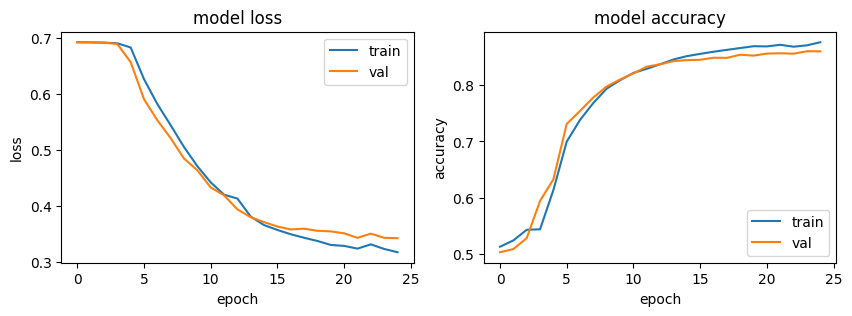

In [7]:
# Set figure size
fig = plt.figure(figsize = (10, 3))

# Visualize the training and validation loss over epochs
ax = fig.add_subplot(1, 2, 1)
plt.plot(lstm_performance.history['loss']); plt.plot(lstm_performance.history['val_loss'])
ax.set_title('model loss'); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.legend(['train', 'val'], loc = 'upper right')

# Visualize the training and validation accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
plt.plot(lstm_performance.history['accuracy']); plt.plot(lstm_performance.history['val_accuracy'])
ax.set_title('model accuracy'); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.legend(['train', 'val'], loc = 'lower right')

plt.show()

Looking at the model accuracy chart, it is clear that there are large fluctuations during epochs 6 and 7. This can be due to the conflict between drastic increase in accuracy and small pre-set learning rate.

However, in the end, the model has converged with the difference between training and validation being small (`~0.01`). Therfore, we predict that the performance on the test set will be close to this (`~0.87`).

## D. GRU Model
### 1. Model Building

Like LSTM model, our GRU will also have 2 Dense layers of `64` units alongside 2 Dropout layers of `0.25` probability.

In [8]:
gru = Sequential([
    text_encoder,
    Embedding( 
        input_dim = len(text_encoder.get_vocabulary()), 
        output_dim = 64,
        mask_zero = True),
    GRU(units = 128),
    Dense(64, activation = 'relu'), Dropout(0.25),
    Dense(64, activation = 'relu'), Dropout(0.25),
    Dense(1, activation='sigmoid')
], name = "GRU")

# Summarize the model
gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                               

### 2. Model Training

Let's compile and train the model with the same set of parameters as LSTM's.

In [9]:
# Compile the model
gru.compile(loss = 'binary_crossentropy',
            optimizer = keras.optimizers.Adam(5e-5),
            metrics = ['accuracy'])

# Train the model
gru_performance = gru.fit(X_train, y_train, epochs = 25, batch_size = 512,
                          validation_data = (X_val, y_val))

Epoch 1/25
40/40 [==============================] - 10s 140ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6930 - val_accuracy: 0.5226
Epoch 2/25
40/40 [==============================] - 5s 115ms/step - loss: 0.6929 - accuracy: 0.5177 - val_loss: 0.6929 - val_accuracy: 0.5306
Epoch 3/25
40/40 [==============================] - 4s 107ms/step - loss: 0.6928 - accuracy: 0.5245 - val_loss: 0.6927 - val_accuracy: 0.5308
Epoch 4/25
40/40 [==============================] - 4s 110ms/step - loss: 0.6926 - accuracy: 0.5326 - val_loss: 0.6925 - val_accuracy: 0.5428
Epoch 5/25
40/40 [==============================] - 5s 120ms/step - loss: 0.6923 - accuracy: 0.5471 - val_loss: 0.6922 - val_accuracy: 0.5494
Epoch 6/25
40/40 [==============================] - 4s 105ms/step - loss: 0.6918 - accuracy: 0.5584 - val_loss: 0.6915 - val_accuracy: 0.5642
Epoch 7/25
40/40 [==============================] - 4s 111ms/step - loss: 0.6908 - accuracy: 0.5728 - val_loss: 0.6901 - val_accuracy: 0.5722
Epoch

Let us see the training and validation performance in terms of loss and accuracy.

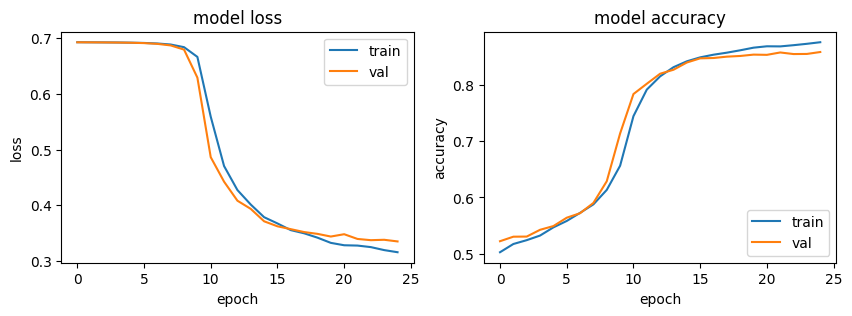

In [10]:
# Set figure size
fig = plt.figure(figsize = (10, 3))

# Visualize the training and validation loss over epochs
ax = fig.add_subplot(1, 2, 1)
plt.plot(gru_performance.history['loss']); plt.plot(gru_performance.history['val_loss'])
ax.set_title('model loss'); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.legend(['train', 'val'], loc = 'upper right')

# Visualize the training and validation accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
plt.plot(gru_performance.history['accuracy']); plt.plot(gru_performance.history['val_accuracy'])
ax.set_title('model accuracy'); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.legend(['train', 'val'], loc = 'lower right')

plt.show()

Looking at the both chart, it is clear that the model has converged with the difference between training and validation being small (`~0.02`). Therfore, we predict that the performance on the test set will be somewhere around `0.86`.

## E. Bidirectional LSTM Model
### 1. Model Building

We continue building a Bidirectional LSTM model the same way as LSTM, except without Dropout layers.

In [11]:
bi_lstm = Sequential([
    text_encoder,
    Embedding( 
        input_dim = len(text_encoder.get_vocabulary()), 
        output_dim = 64,
        mask_zero = True),
    Bidirectional(layer = LSTM(units = 128)),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
], name = "Bidirectional-LSTM")

# Summarize the model
bi_lstm.summary()

Model: "Bidirectional-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)          

We see that the number of parameters of bidirectional LSTM are significantly larger than that of LSTM. Although the number of parameters does not correspond to higher performance in general case, we believe that it will in this situation.

### 2. Model Training

Let's compile and train the model with the same set of parameters as LSTM's.

In [12]:
# Compile the model
bi_lstm.compile(loss = 'binary_crossentropy',
                optimizer = keras.optimizers.Adam(5e-5),
                metrics = ['accuracy'])

# Train the model
bi_lstm_performance = bi_lstm.fit(X_train, y_train, epochs = 25, batch_size = 512,
                                  validation_data = (X_val, y_val))

Epoch 1/25
40/40 [==============================] - 18s 272ms/step - loss: 0.6931 - accuracy: 0.5202 - val_loss: 0.6929 - val_accuracy: 0.5446
Epoch 2/25
40/40 [==============================] - 9s 217ms/step - loss: 0.6926 - accuracy: 0.5611 - val_loss: 0.6923 - val_accuracy: 0.5666
Epoch 3/25
40/40 [==============================] - 8s 207ms/step - loss: 0.6916 - accuracy: 0.5870 - val_loss: 0.6905 - val_accuracy: 0.5990
Epoch 4/25
40/40 [==============================] - 8s 201ms/step - loss: 0.6874 - accuracy: 0.6218 - val_loss: 0.6810 - val_accuracy: 0.6340
Epoch 5/25
40/40 [==============================] - 8s 201ms/step - loss: 0.6435 - accuracy: 0.6637 - val_loss: 0.6432 - val_accuracy: 0.6782
Epoch 6/25
40/40 [==============================] - 8s 208ms/step - loss: 0.5893 - accuracy: 0.7053 - val_loss: 0.5775 - val_accuracy: 0.6828
Epoch 7/25
40/40 [==============================] - 8s 198ms/step - loss: 0.5361 - accuracy: 0.7406 - val_loss: 0.5073 - val_accuracy: 0.7648
Epoch

Let us see the training and validation performance in terms of loss and accuracy.

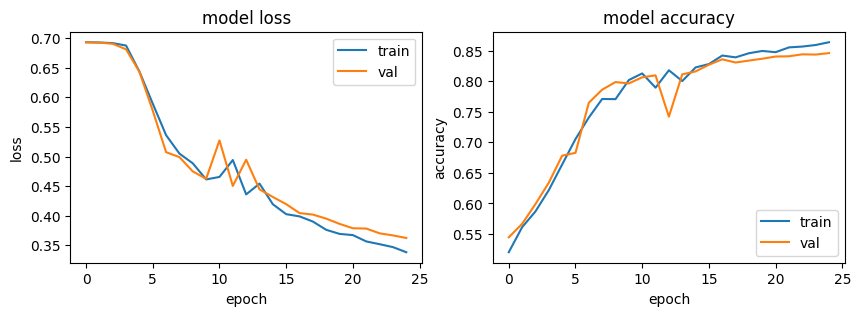

In [13]:
# Set figure size
fig = plt.figure(figsize = (10, 3))

# Visualize the training and validation loss over epochs
ax = fig.add_subplot(1, 2, 1)
plt.plot(bi_lstm_performance.history['loss']); plt.plot(bi_lstm_performance.history['val_loss'])
ax.set_title('model loss'); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.legend(['train', 'val'], loc = 'upper right')

# Visualize the training and validation accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
plt.plot(bi_lstm_performance.history['accuracy']); plt.plot(bi_lstm_performance.history['val_accuracy'])
ax.set_title('model accuracy'); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.legend(['train', 'val'], loc = 'lower right')

plt.show()

Interestingly, the result for Bi-LSTM is not significantly different from LSTM. The model converged at `0.86` with a small difference between training and validation (`~0.02`).

## F. Conv1D Model
### 1. Model Building

We build simple 1D convolution network with 3 blocks of Conv1D + MaxPooling1D and 1 classifiers block of 1 GlobalMaxPooling1D + 3 Dense at the end.

In [14]:
conv1d = Sequential([
    text_encoder,
    Embedding( 
        input_dim = len(text_encoder.get_vocabulary()), 
        output_dim = 64,
        mask_zero = True),
    Conv1D(filters = 128, kernel_size = 3, activation = 'relu'), MaxPooling1D(3),
    Conv1D(filters = 128, kernel_size = 3, activation = 'relu'), MaxPooling1D(3),
    Conv1D(filters = 128, kernel_size = 3, activation = 'relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation = 'relu'), Dropout(0.25),
    Dense(64, activation = 'relu'), Dropout(0.25),
    Dense(1, activation = 'sigmoid')
], name = "1D_Convolution_Network")

# Summarize the model
conv1d.summary()

Model: "1D_Convolution_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 conv1d (Conv1D)             (None, None, 128)         24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 1

### 2. Model Training

Let's compile and train the model with the same set of parameters as LSTM's.

In [15]:
# Compile the model
conv1d.compile(loss = 'binary_crossentropy',
               optimizer = keras.optimizers.Adam(5e-5),
               metrics = ['accuracy'])

# Train the model
conv1d_performance = conv1d.fit(X_train, y_train, epochs = 25, batch_size = 512,
                                validation_data = (X_val, y_val))

Epoch 1/25
40/40 [==============================] - 49s 1s/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.4938
Epoch 2/25
40/40 [==============================] - 16s 402ms/step - loss: 0.6929 - accuracy: 0.5099 - val_loss: 0.6929 - val_accuracy: 0.4950
Epoch 3/25
40/40 [==============================] - 12s 312ms/step - loss: 0.6925 - accuracy: 0.5126 - val_loss: 0.6927 - val_accuracy: 0.4958
Epoch 4/25
40/40 [==============================] - 7s 170ms/step - loss: 0.6922 - accuracy: 0.5171 - val_loss: 0.6920 - val_accuracy: 0.5552
Epoch 5/25
40/40 [==============================] - 8s 199ms/step - loss: 0.6915 - accuracy: 0.5408 - val_loss: 0.6910 - val_accuracy: 0.5932
Epoch 6/25
40/40 [==============================] - 8s 213ms/step - loss: 0.6901 - accuracy: 0.5625 - val_loss: 0.6894 - val_accuracy: 0.5364
Epoch 7/25
40/40 [==============================] - 7s 180ms/step - loss: 0.6872 - accuracy: 0.5836 - val_loss: 0.6850 - val_accuracy: 0.6228
Epoch 

Let us see the training and validation performance in terms of loss and accuracy.

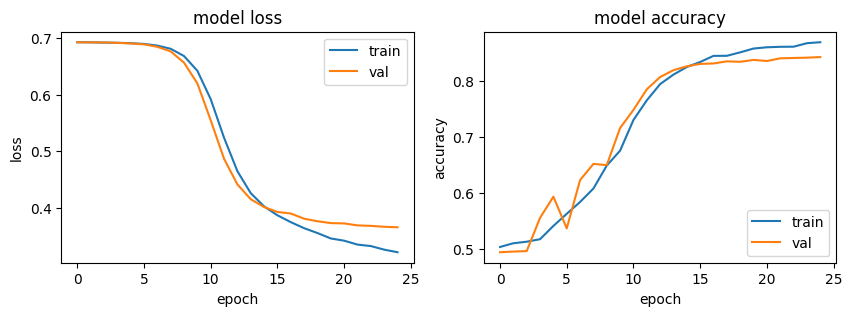

In [16]:
# Set figure size
fig = plt.figure(figsize = (10, 3))

# Visualize the training and validation loss over epochs
ax = fig.add_subplot(1, 2, 1)
plt.plot(conv1d_performance.history['loss']); plt.plot(conv1d_performance.history['val_loss'])
ax.set_title('model loss'); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.legend(['train', 'val'], loc = 'upper right')

# Visualize the training and validation accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
plt.plot(conv1d_performance.history['accuracy']); plt.plot(conv1d_performance.history['val_accuracy'])
ax.set_title('model accuracy'); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.legend(['train', 'val'], loc = 'lower right')

plt.show()

Like other models, this model obtains the the performance of `~0.85` accuracy when converged. This value is also reliable as the difference between training and validation accuray is small (`~0.02`).

## G. Conv1D Model with Transfer Learning using GloVe
### 1. Load pre-trained word embeddings

Let's download the most lighweighted pre-trained GloVe embedding that uses [Wikipedia 2014](http://dumps.wikimedia.org/enwiki/20140102/) + [Gigaword 5](https://catalog.ldc.upenn.edu/LDC2011T07) dataset (6B tokens, 822MB).

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip  --quiet
!unzip -q glove.6B.zip

We'll use the 100-dimensional text-encoded vector to make a numpy vector mapping words.

In [18]:
# Get the 50D text-encoded vector from GloVe's 6B
embeddings_index = {}
with open("glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

### 2. Model Building

Now, let's prepare a corresponding embedding matrix that we can use in a Keras
`Embedding` layer. Since we use 100D text-encoder, the input and output dimension of the Embedding layer must be `100`. Moreover as we don't want the pre-trained weights to be updated during training, we set `trainable = False`.

In [36]:
# Prepare Embedding matrix
embedding_matrix = np.zeros((len(text_encoder.get_vocabulary()), 100))
for i in range(len(vocab)):
    embedding_vector = embeddings_index.get(vocab[i])
    # Words not found in embedding index will be all-zeros
    embedding_matrix[i] = embedding_vector if embedding_vector is not None else 0

# Customize the Embedding layer
conv1d_tl = Sequential([
    text_encoder,
    Embedding(
        input_dim = len(text_encoder.get_vocabulary()), 
        output_dim = 100,
        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
        trainable = False),
    Conv1D(filters = 200, kernel_size = 3, activation = 'relu'), MaxPooling1D(3),
    Conv1D(filters = 200, kernel_size = 3, activation = 'relu'), MaxPooling1D(3),
    Conv1D(filters = 200, kernel_size = 3, activation = 'relu'),
    GlobalMaxPooling1D(),
    Dense(100, activation = 'relu'), Dropout(0.25),
    Dense(100, activation = 'relu'), Dropout(0.25),
    Dense(1, activation = 'sigmoid')
], name = "1D_Convolution_Network_with_Transfer_Learning")

# Summarize the model
conv1d_tl.summary()

Model: "1D_Convolution_Network_with_Transfer_Learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_8 (Embedding)     (None, None, 100)         100000    
                                                                 
 conv1d_15 (Conv1D)          (None, None, 200)         60200     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, None, 200)        0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, None, 200)         120200    
                                                                 
 max_pooling1d_11 (Ma

Since we freeze the Embedding layer, the number of trainable parameters is  `330K`, which is still a large number comparing to other models.

### 3. Model Training

Now, we train the model. We will divide the model training into 2 consecutive phrases as said before: without and with updating the base model's weights.

#### a. Phase 1: Without Updating Weights

The goal of this phrase is to obtain the best model as possible and to reach the coverage of training and validation's accuracy. We will use the same set of parameters as LSTM's, except changing epochs to `15`.

In [37]:
# Compile the model
conv1d_tl.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(5e-5),
                  metrics = ['accuracy'])

# Train the model
conv1d_tl_performance_1 = conv1d_tl.fit(X_train, y_train, epochs = 20, batch_size = 512,
                                        validation_data = (X_val, y_val))

Epoch 1/20
40/40 [==============================] - 10s 239ms/step - loss: 0.6998 - accuracy: 0.5063 - val_loss: 0.6910 - val_accuracy: 0.5248
Epoch 2/20
40/40 [==============================] - 9s 236ms/step - loss: 0.6914 - accuracy: 0.5234 - val_loss: 0.6865 - val_accuracy: 0.5934
Epoch 3/20
40/40 [==============================] - 9s 222ms/step - loss: 0.6849 - accuracy: 0.5622 - val_loss: 0.6849 - val_accuracy: 0.5200
Epoch 4/20
40/40 [==============================] - 9s 239ms/step - loss: 0.6782 - accuracy: 0.5877 - val_loss: 0.6687 - val_accuracy: 0.6304
Epoch 5/20
40/40 [==============================] - 9s 237ms/step - loss: 0.6658 - accuracy: 0.6142 - val_loss: 0.6538 - val_accuracy: 0.6470
Epoch 6/20
40/40 [==============================] - 11s 271ms/step - loss: 0.6501 - accuracy: 0.6374 - val_loss: 0.6336 - val_accuracy: 0.6728
Epoch 7/20
40/40 [==============================] - 10s 243ms/step - loss: 0.6294 - accuracy: 0.6604 - val_loss: 0.6087 - val_accuracy: 0.6944
Epo

We see that the model coveraged at `0.81` accuracy.

#### b. Phase 2: With Updating Weights

Having the model coverages, we unfreeze the base model and let the weight change so that we can have a better model. We will run the last `5` epochs.

In [38]:
# Unfreeze the base model
conv1d_tl.trainable = True

# Recompile the model
conv1d_tl.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(1e-5),
                  metrics = ['accuracy'])

# Train the model
conv1d_tl_performance_2 = conv1d_tl.fit(X_train, y_train, epochs = 5, batch_size = 512,
                                        validation_data = (X_val, y_val))

Epoch 1/5
40/40 [==============================] - 12s 290ms/step - loss: 0.4003 - accuracy: 0.8255 - val_loss: 0.4221 - val_accuracy: 0.8038
Epoch 2/5
40/40 [==============================] - 11s 266ms/step - loss: 0.3966 - accuracy: 0.8285 - val_loss: 0.4217 - val_accuracy: 0.8062
Epoch 3/5
40/40 [==============================] - 14s 339ms/step - loss: 0.3979 - accuracy: 0.8270 - val_loss: 0.4247 - val_accuracy: 0.8032
Epoch 4/5
40/40 [==============================] - 13s 321ms/step - loss: 0.3947 - accuracy: 0.8271 - val_loss: 0.4203 - val_accuracy: 0.8076
Epoch 5/5
40/40 [==============================] - 10s 260ms/step - loss: 0.3903 - accuracy: 0.8346 - val_loss: 0.4189 - val_accuracy: 0.8070


#### c. Performance
Let us see the training and validation performance in terms of loss and accuracy.

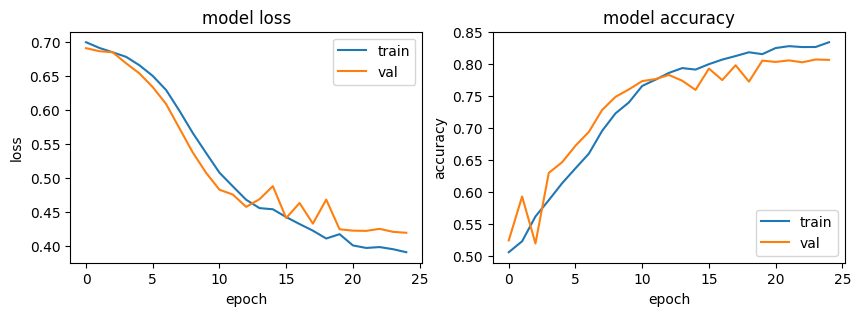

In [39]:
# Append the second training results into the first one
metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
conv1d_tl_performance = {i: conv1d_tl_performance_1.history[i] + conv1d_tl_performance_2.history[i] for i in metrics}

# Set figure size
fig = plt.figure(figsize = (10, 3))

# Visualize the training and validation loss over epochs
ax = fig.add_subplot(1, 2, 1)
plt.plot(conv1d_tl_performance['loss']); plt.plot(conv1d_tl_performance['val_loss'])
ax.set_title('model loss'); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.legend(['train', 'val'], loc = 'upper right')

# Visualize the training and validation accuracy over epochs
ax = fig.add_subplot(1, 2, 2)
plt.plot(conv1d_tl_performance['accuracy']); plt.plot(conv1d_tl_performance['val_accuracy'])
ax.set_title('model accuracy'); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.legend(['train', 'val'], loc = 'lower right')

plt.show()

We obtain a reasonably poor performance with only `0.83` accuracy and reasonable gap betwwen validation and training (`0.03`).

## H. Model Comparison

We compare our models' performance on the test set.

In [40]:
# Get the list of models and its performance on the test set
models = {'LSTM': lstm.evaluate(X_test, y_test),
          'GRU': gru.evaluate(X_test, y_test),
          'Bi-LSTM': bi_lstm.evaluate(X_test, y_test),
          'Conv1D': conv1d.evaluate(X_test, y_test),
          'Conv1D with GloVe': conv1d_tl.evaluate(X_test, y_test)}

# Visualize their performance in a table
table1 = [['Model', 'Test loss', 'Test accuracy']]
for name in models.keys():
  table1.append([name, models[name][0], models[name][1]])

# Display comparision table
print(); print(tabulate(table1, headers = 'firstrow', tablefmt = 'rounded_outline'))

782/782 [==============================] - 8s 10ms/step - loss: 0.4226 - accuracy: 0.8040

Model                Test loss    Test accuracy
-----------------  -----------  ---------------
LSTM                  0.333048          0.85952
GRU                   0.329993          0.8592
Bi-LSTM               0.352294          0.853
Conv1D                0.366243          0.83916
Conv1D with GloVe     0.42265           0.80396


From the comparison table, we see that the loss and accuracy on the test set of LSTM, GRU, and Bi-LSTM is quite the same (`~0.33` and `~0.85`, respectively). However, Bi-LSTM takes longer time per step to run, comparing with LSTM and GRU.

For a RNN with Conv1D, it is clear that the performance isn't as good as others RNNs, in terms of accuracy, loss, and running time. Without using GloVe, We obtain an accuracy of `0.83`. Moreover, it is interesting that with GloVe, the accuracy drops to `0.80`. We guess that this is because of small learning rate and small number of epochs.